# Simultaneous Wavelength Mode with MC

In this example we perform a full radiative transfer calculation using the simultaneous wavelength mode of the MC model. Radiances at different wavelengths are calculated using common ray tracing, reducing computation time and greatly increasing correlation between wavelengths.

In [1]:
%matplotlib inline

In [2]:
import sasktran as sk
import matplotlib.pyplot as plt
import numpy as np
from sasktran.geometry import VerticalImage

# First recreate our geometry and atmosphere classes
geometry = VerticalImage()
geometry.from_sza_saa(sza=60, saa=60, lat=0, lon=0, tanalts_km=[20], mjd=54372, locallook=0,
                      satalt_km=600, refalt_km=20)

atmosphere = sk.Atmosphere()
atmosphere['ozone'] = sk.Species(sk.O3OSIRISRes(), sk.Labow())
atmosphere['air'] = sk.Species(sk.Rayleigh(), sk.MSIS90())
atmosphere.brdf = 1.0

# And now make the engine
engine = sk.EngineMC(geometry=geometry, atmosphere=atmosphere)

engine.max_photons_per_los = 300   # cap the calculation at 300 rays per line of sight
engine.solar_table_type = 0        # calculate single scatter source terms on the fly; no cache
engine.debug_mode = 1234           # disable multi-threading, fix the rng seed for reproducibility

# Choose some wavelengths to do the calculation at
engine.wavelengths = np.arange(332, 337, 0.5)

# And do the calculation in simultaneous wavelength mode
engine.simultaneous_wavelength = True
simultaneous_output = engine.calculate_radiance()

# Repeat without simultaneous wavelength mode
engine.simultaneous_wavelength = False
separate_output = engine.calculate_radiance()

In [3]:
# calculate HR for reference
engine = sk.EngineHR(geometry=geometry, atmosphere=atmosphere)
engine.wavelengths = np.arange(332, 337, 0.5)
radiance = engine.calculate_radiance()

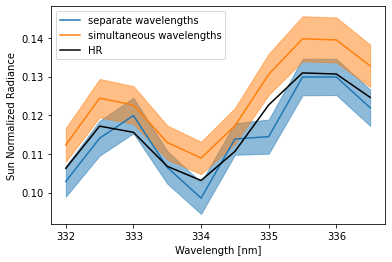

In [4]:
wl = engine.wavelengths

rad = separate_output.radiance[:, 0]
std = np.sqrt(separate_output.radiance_variance[:, 0])
plt.plot(wl, rad, 'C0')
plt.fill_between(wl, rad - std, rad + std, color='C0', alpha=0.5)

rad = simultaneous_output.radiance[:, 0]
std = np.sqrt(simultaneous_output.radiance_variance[:, 0])
plt.plot(wl, rad, 'C1')
plt.fill_between(wl, rad - std, rad + std, color='C1', alpha=0.5)

plt.plot(wl, radiance, 'k')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Sun Normalized Radiance')
plt.legend(['separate wavelengths', 'simultaneous wavelengths', 'HR'])

plt.show()